In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors
import pandas as pd
from random import uniform

import sys
sys.path.append('../')
from database.models import get_db_session, AccidentDBScan

In [2]:
# Obtain accidents
session = get_db_session('sqlite:///../incidences.db')
accidents = session.query(AccidentDBScan.longitud, 
                          AccidentDBScan.latitud,
                          AccidentDBScan.num_cluster).all()

print('Number of accidents = {}'.format(len(accidents)))

Number of accidents = 7939


In [3]:
# Function for obtain random accidents to train KNN
def shuffle_accidents(p, accidents):
    train = []
    test = []
    for accident in accidents:
        if uniform(0, 1) < p:
            train.append(accident)
        else:
            test.append(accident)
    return [train, test]

In [4]:
# We repeat the process of choosing the best K 60 times
# to obtain the average number of errors

train_p = 0.6
repetitions = 60
k_errors = [0 for x in range(repetitions)]

for rep in range(repetitions):
    train, test = shuffle_accidents(train_p, accidents)
    lat_and_lon_train = [x[:2] for x in train]
    lat_and_lon_test = [x[:2] for x in test]
    zone_train = [x[2] for x in train]
    zone_test = [x[2] for x in test]
    for n_neighbors in range(1, repetitions):
        clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
        clf.fit(lat_and_lon_train, zone_train)
        Z = clf.predict(lat_and_lon_test)
        err = (zone_test != Z).sum() / len(test)
        k_errors[n_neighbors] += err

In [14]:
errors = list(map(lambda x : x / repetitions, k_errors))

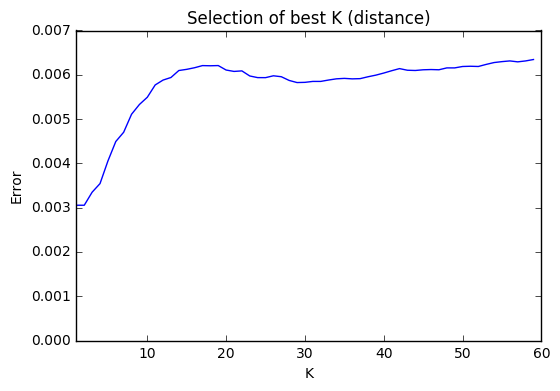

In [16]:
# Plot the result

plt.title('Selection of best K (distance)')
plt.ylabel('Error')
plt.xlabel('K')
plt.xlim(1, repetitions)
plt.plot(errors)
plt.show()

In [7]:
# We choose K=2 to apply KNN to work accidents
lat_and_lon_train = [x[:2] for x in accidents]
zone_train = [x[2] for x in accidents]
clf = neighbors.KNeighborsClassifier(2, weights='distance')
clf.fit(lat_and_lon_train, zone_train)

Z = clf.predict(lat_and_lon_train)

array([b'', b'\r', b'\x01', ..., b'\t', b'\t', b'\x06'], 
      dtype='|S8')